# Key Phrase Analysis

This notebook performs an analysis to identify key phrases used by account executives in sales transcripts and evaluates their impact on sales outcomes using embeddings and clustering techniques. We'll follow a systematic workflow that includes data loading, text preprocessing, embedding generation, clustering, key phrase extraction, statistical analysis, and interpretation.

## Table of Contents
1. [Introduction](#introduction)
2. [Data Loading and Preparation](#data-loading-and-preparation)
3. [Text Preprocessing](#text-preprocessing)
4. [Embedding Generation](#embedding-generation)
5. [Clustering Embeddings](#clustering-embeddings)
6. [Key Phrase Extraction](#key-phrase-extraction)
7. [Data Aggregation](#data-aggregation)
8. [Statistical Analysis](#statistical-analysis)
9. [Model Interpretation](#model-interpretation)
10. [Visualization](#visualization)
11. [Conclusion](#conclusion)

---


In [ ]:
# Install necessary packages
import subprocess
import sys

# Install tqdm
subprocess.check_call([sys.executable, "-m", "pip", "install", "tqdm"])

from tqdm.notebook import tqdm

packages = [
    "pandas", "matplotlib", "seaborn", "scipy",
    "scikit-learn", "sentence_transformers", "nltk", "umap-learn",
    "imblearn", "gspread", "spacy", "numpy<2.0", "threadpoolctl"
]

# Install packages individually with tqdm progress bar
for package in tqdm(packages, desc="Installing packages"):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

result = subprocess.run("python -m spacy download en_core_web_sm", shell=True, capture_output=True, text=True)

In [1]:
# Import necessary libraries

# Download NLTK data
import nltk
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)
nltk.download('wordnet', quiet=True)

# Import spaCy and load the English language model
import spacy

# Load the spaCy English model
nlp = spacy.load('en_core_web_sm')

import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# NLP libraries
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer

# Embedding and clustering libraries
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer

# Statistical libraries
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import MultiLabelBinarizer
from imblearn.over_sampling import SMOTE

# Progress bar
from tqdm.notebook import tqdm

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Display settings
%matplotlib inline
pd.set_option('display.max_columns', None)

# For reproducibility
np.random.seed(42)


C:\Users\Dan Labrador\AppData\Roaming\Python\Python312\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


<a id='introduction'></a>
## 1. Introduction

The goal of this analysis is to identify key phrases used by account executives in sales transcripts and determine their impact on sales outcomes. By leveraging embeddings and clustering techniques, we aim to uncover phrases that correlate with successful sales (`closed_won`) or longer sales cycles.

**Data Structure:**

- **IDs List (`ids`):** A list of dictionaries containing transcript IDs and their corresponding sales outcomes.
- **Meeting Data (`meeting_df`):** Contains meeting-level information for each transcript (does not include `sales_outcome`).
- **Sentences Data (`sentences_df`):** Contains sentence-level data, including speaker information and the text spoken.

**Steps Involved:**

1. Load and prepare the data from multiple transcripts.
2. Preprocess the text data.
3. Generate embeddings for sentences spoken by account executives.
4. Cluster the embeddings to identify key phrases.
5. Extract representative key phrases for each cluster.
6. Aggregate data at the meeting level.
7. Perform statistical analysis to identify significant phrases.
8. Interpret the model coefficients and provide insights.
9. Visualize the results.
10. Draw conclusions and suggest actionable insights.


In [2]:
# For reproducibility
np.random.seed(42)


<a id='data-loading-and-preparation'></a>
## 2. Data Loading and Preparation

We'll start by loading the dataset from multiple transcripts and preparing it for analysis.

### Import Necessary Libraries

*This section has already been covered in the previous code cells.*


In [3]:
from services.gspread import (
    gspread_try_get_cells_by_range,
    gspread_try_get_service_account_from_file,
    gspread_try_get_spreadsheet_by_id,
    gspread_try_get_worksheet_by_id
)

# Get data from Google Sheets
service_account = gspread_try_get_service_account_from_file('secret_sales_meetings_report_service_account.json')
spreadsheet = gspread_try_get_spreadsheet_by_id(
    service_account,
    '19AYpEl2TeqUAAZ-pqGU3c9j6rtzzFbWgRrEjHA_ozYM'  # Production spreadsheet
)
sheet_metrics_per_transcript = gspread_try_get_worksheet_by_id(spreadsheet, 1963712501)

# Fetch IDs from Google Sheets
ids = gspread_try_get_cells_by_range(sheet_metrics_per_transcript, 'A3:E')

# Convert list of dictionaries
ids = [
    {
        'id': row[0],
        'sales_outcome': row[4],
    }
    for row in ids
]

# Limit to first and last 100 IDs for demonstration
ids = ids[:100] + ids[-100:]

from algorithms.get_transcript import get_transcript_dfs

# Convert the list of dictionaries to a DataFrame and remove duplicates
ids_df = pd.DataFrame(ids)
ids_df = ids_df.drop_duplicates(subset='id')
ids = ids_df.to_dict('records')

# Initialize an empty list to store all sentences
all_sentences = []

# Iterate over the IDs with tqdm for progress tracking
for item in tqdm(ids, desc="Processing IDs"):
    transcript_id = item['id']
    sales_outcome = item['sales_outcome']
    
    # Fetch the dataframes
    transcript_dfs = get_transcript_dfs(transcript_id)
    meeting_df = transcript_dfs['meeting_df']
    sentences_df = transcript_dfs['sentences_df']
    
    # Since meeting_df doesn't have 'sales_outcome', we'll add it
    # meeting_df['sales_outcome'] = sales_outcome  # Removed to fix TypeError
    sentences_df['sales_outcome'] = sales_outcome
    sentences_df['id'] = transcript_id
    
    # Filter for account executives
    ae_sentences = sentences_df[sentences_df['is_account_executive']]
    
    # Append to list
    all_sentences.append(ae_sentences)

# Concatenate all sentences into a single DataFrame
all_sentences_df = pd.concat(all_sentences, ignore_index=True)

# Display the first few rows
all_sentences_df.head()


Processing IDs:   0%|          | 0/194 [00:00<?, ?it/s]

HTTPError: 502 Server Error: Bad Gateway for url: https://api.fireflies.ai/graphql
HTTPError: 502 Server Error: Bad Gateway for url: https://api.fireflies.ai/graphql


,speaker_name,speaker_id,text,start_time,end_time,task,pricing,metric,question,date_and_time,sentiment,speaker_email,is_account_executive,sales_outcome,id
0,Shawn Henderson,0,Time out of your day to meet with me.,0.330,2.302,None,None,None,None,None,None,shawn.henderson@myamazonguy.com,True,closed_lost,FxuRiyttDW782zH3
1,Shawn Henderson,0,I know that my assistant Ian emailed you a vid...,2.356,6.800,None,None,None,I know that my assistant Ian emailed you a vid...,None,None,shawn.henderson@myamazonguy.com,True,closed_lost,FxuRiyttDW782zH3
2,Shawn Henderson,0,Yeah.,8.634,9.182,None,None,None,None,None,None,shawn.henderson@myamazonguy.com,True,closed_lost,FxuRiyttDW782zH3
3,Shawn Henderson,0,Albert Ian.,9.316,10.458,None,None,None,None,None,None,shawn.henderson@myamazonguy.com,True,closed_lost,FxuRiyttDW782zH3
4,Shawn Henderson,0,"Okay, awesome.",10.634,12.960,None,None,None,None,None,None,shawn.henderson@myamazonguy.com,True,closed_lost,FxuRiyttDW782zH3


---
<a id='text-preprocessing'></a>
## 3. Text Preprocessing

We'll clean and prepare the text data for embedding generation, focusing on extracting meaningful content by retaining only nouns and verbs. We'll set up the text preprocessing procedure to break down each sentence into individual phrases. This way, each noun or noun phrase will be treated separately, allowing for more granular analysis.


In [4]:
# Import necessary spaCy modules
from nltk.stem import WordNetLemmatizer
from tqdm.notebook import tqdm
import pandas as pd
from nltk.corpus import stopwords

# Initialize stop words and lemmatizer
stop_words = set(stopwords.words('english'))
custom_stop_words = stop_words.union({'yeah', 'um', 'so', 'like', 'uh', 'hmm'})
lemmatizer = WordNetLemmatizer()

def preprocess_text_spacy_adj_nouns(text):
    # Check for NaN
    if pd.isnull(text):
        return []
    
    # Process the text with spaCy
    doc = nlp(text.lower())
    
    # Initialize list to hold meaningful phrases
    phrases = []
    
    # Extract noun chunks (noun phrases)
    for chunk in doc.noun_chunks:
        # Collect adjectives and nouns within the chunk
        tokens = [
            token.text
            for token in chunk
            if token.pos_ in ['ADJ', 'NOUN', 'PROPN'] and token.is_alpha and not token.is_stop and token.text not in custom_stop_words
        ]
        if tokens:
            phrase = ' '.join(tokens)
            phrases.append(phrase)
    
    # Extract named entities
    entities = [
        ent.text.lower()
        for ent in doc.ents
        if ent.label_ in ['PERSON', 'ORG', 'GPE', 'PRODUCT', 'EVENT']
    ]
    phrases.extend(entities)
    
    # Remove duplicates while preserving order
    seen = set()
    unique_phrases = []
    for phrase in phrases:
        if phrase not in seen:
            seen.add(phrase)
            unique_phrases.append(phrase)
    
    return unique_phrases


# Enable the tqdm progress bar for pandas apply
tqdm.pandas()

# Apply the updated preprocessing function
all_sentences_df['phrases'] = all_sentences_df['text'].progress_apply(preprocess_text_spacy_adj_nouns)

# Display the phrases
all_sentences_df[['text', 'phrases']].head()


  0%|          | 0/56804 [00:00<?, ?it/s]

,text,phrases
0,Time out of your day to meet with me.,"[time, day]"
1,I know that my assistant Ian emailed you a vid...,"[assistant ian, video]"
2,Yeah.,[]
3,Albert Ian.,[albert ian]
4,"Okay, awesome.",[]


### Explode Phrases Into Separate Rows

We will expand the DataFrame so that each phrase has its own row.

In [5]:
# Explode the phrases into separate rows
expanded_df = all_sentences_df.explode('phrases').reset_index(drop=True)

# Rename 'phrases' to 'clean_text' for consistency
expanded_df.rename(columns={'phrases': 'clean_text'}, inplace=True)

# Drop rows where 'clean_text' is NaN or empty
expanded_df = expanded_df[expanded_df['clean_text'].notna() & (expanded_df['clean_text'] != '')]

# Display the expanded DataFrame
expanded_df.head()


,speaker_name,speaker_id,text,start_time,end_time,task,pricing,metric,question,date_and_time,sentiment,speaker_email,is_account_executive,sales_outcome,id,clean_text
0,Shawn Henderson,0,Time out of your day to meet with me.,0.330,2.302,None,None,None,None,None,None,shawn.henderson@myamazonguy.com,True,closed_lost,FxuRiyttDW782zH3,time
1,Shawn Henderson,0,Time out of your day to meet with me.,0.330,2.302,None,None,None,None,None,None,shawn.henderson@myamazonguy.com,True,closed_lost,FxuRiyttDW782zH3,day
2,Shawn Henderson,0,I know that my assistant Ian emailed you a vid...,2.356,6.800,None,None,None,I know that my assistant Ian emailed you a vid...,None,None,shawn.henderson@myamazonguy.com,True,closed_lost,FxuRiyttDW782zH3,assistant ian
3,Shawn Henderson,0,I know that my assistant Ian emailed you a vid...,2.356,6.800,None,None,None,I know that my assistant Ian emailed you a vid...,None,None,shawn.henderson@myamazonguy.com,True,closed_lost,FxuRiyttDW782zH3,video
5,Shawn Henderson,0,Albert Ian.,9.316,10.458,None,None,None,None,None,None,shawn.henderson@myamazonguy.com,True,closed_lost,FxuRiyttDW782zH3,albert ian


---
<a id='embedding-generation'></a>
## 4. Embedding Generation

We'll generate embeddings for each sentence using a pre-trained model.


In [6]:
# Load the model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Generate embeddings using the individual phrases
embeddings = model.encode(expanded_df['clean_text'].tolist(), show_progress_bar=True)

# Add embeddings to DataFrame
expanded_df['embedding'] = embeddings.tolist()

# Display the first few embeddings
expanded_df.head()


Batches:   0%|          | 0/2421 [00:00<?, ?it/s]

,speaker_name,speaker_id,text,start_time,end_time,task,pricing,metric,question,date_and_time,sentiment,speaker_email,is_account_executive,sales_outcome,id,clean_text,embedding
0,Shawn Henderson,0,Time out of your day to meet with me.,0.330,2.302,None,None,None,None,None,None,shawn.henderson@myamazonguy.com,True,closed_lost,FxuRiyttDW782zH3,time,"[-0.07450684159994125, 0.05483793839812279, -0..."
1,Shawn Henderson,0,Time out of your day to meet with me.,0.330,2.302,None,None,None,None,None,None,shawn.henderson@myamazonguy.com,True,closed_lost,FxuRiyttDW782zH3,day,"[-0.07447903603315353, 0.10445287078619003, 0...."
2,Shawn Henderson,0,I know that my assistant Ian emailed you a vid...,2.356,6.800,None,None,None,I know that my assistant Ian emailed you a vid...,None,None,shawn.henderson@myamazonguy.com,True,closed_lost,FxuRiyttDW782zH3,assistant ian,"[-0.051274336874485016, -0.01787455566227436, ..."
3,Shawn Henderson,0,I know that my assistant Ian emailed you a vid...,2.356,6.800,None,None,None,I know that my assistant Ian emailed you a vid...,None,None,shawn.henderson@myamazonguy.com,True,closed_lost,FxuRiyttDW782zH3,video,"[-0.02528737485408783, -0.0293726809322834, -0..."
5,Shawn Henderson,0,Albert Ian.,9.316,10.458,None,None,None,None,None,None,shawn.henderson@myamazonguy.com,True,closed_lost,FxuRiyttDW782zH3,albert ian,"[0.01953824982047081, 0.05840739607810974, -0...."


---
<a id='clustering-embeddings'></a>
## 5. Clustering Embeddings

We'll cluster the sentence embeddings to identify groups of similar phrases.


In [7]:
# Step 2: Import os to set environment variables
import os

# Step 3: Limit the number of threads used by BLAS libraries
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"

# Import necessary libraries
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Convert embeddings to array
embedding_array = np.array(expanded_df['embedding'].tolist())

# Optional: Dimensionality Reduction using PCA
pca = PCA(n_components=0.95, random_state=42)  # Retain 95% variance
reduced_embeddings = pca.fit_transform(embedding_array)

# Determine optimal number of clusters
num_clusters = 50

# Clustering using KMeans
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(reduced_embeddings)

# Assign cluster labels
expanded_df['cluster'] = kmeans.labels_

# Display cluster assignments
expanded_df.head()


,speaker_name,speaker_id,text,start_time,end_time,task,pricing,metric,question,date_and_time,sentiment,speaker_email,is_account_executive,sales_outcome,id,clean_text,embedding,cluster
0,Shawn Henderson,0,Time out of your day to meet with me.,0.330,2.302,None,None,None,None,None,None,shawn.henderson@myamazonguy.com,True,closed_lost,FxuRiyttDW782zH3,time,"[-0.07450684159994125, 0.05483793839812279, -0...",2
1,Shawn Henderson,0,Time out of your day to meet with me.,0.330,2.302,None,None,None,None,None,None,shawn.henderson@myamazonguy.com,True,closed_lost,FxuRiyttDW782zH3,day,"[-0.07447903603315353, 0.10445287078619003, 0....",24
2,Shawn Henderson,0,I know that my assistant Ian emailed you a vid...,2.356,6.800,None,None,None,I know that my assistant Ian emailed you a vid...,None,None,shawn.henderson@myamazonguy.com,True,closed_lost,FxuRiyttDW782zH3,assistant ian,"[-0.051274336874485016, -0.01787455566227436, ...",7
3,Shawn Henderson,0,I know that my assistant Ian emailed you a vid...,2.356,6.800,None,None,None,I know that my assistant Ian emailed you a vid...,None,None,shawn.henderson@myamazonguy.com,True,closed_lost,FxuRiyttDW782zH3,video,"[-0.02528737485408783, -0.0293726809322834, -0...",6
5,Shawn Henderson,0,Albert Ian.,9.316,10.458,None,None,None,None,None,None,shawn.henderson@myamazonguy.com,True,closed_lost,FxuRiyttDW782zH3,albert ian,"[0.01953824982047081, 0.05840739607810974, -0....",7


**Recommendation:**
- **Adjust `num_clusters`:** Depending on the dataset size (~2500 transcripts), you might need a higher number of clusters to capture diverse key phrases effectively.

---

<a id='key-phrase-extraction'></a>
## 6. Key Phrase Extraction

We'll extract representative key phrases for each cluster by focusing on meaningful content (nouns and verbs).


In [8]:
# Initialize a dictionary to store cluster labels
cluster_labels = {}

for cluster_num in range(num_clusters):
    # Filter phrases in the cluster
    cluster_phrases = expanded_df[expanded_df['cluster'] == cluster_num]
    
    if cluster_phrases.empty:
        # Assign 'N/A' if the cluster has no phrases
        key_phrase = 'N/A'
        print(f"Cluster {cluster_num} has no phrases. Assigned key phrase: {key_phrase}\n")
    else:
        # Get all phrases in the cluster
        phrases = cluster_phrases['clean_text'].tolist()
        
        # Count the frequency of each phrase
        phrase_counts = pd.Series(phrases).value_counts()
        
        # Assign the most frequent phrase as the key phrase
        key_phrase = phrase_counts.index[0]
        print(f"Cluster {cluster_num} assigned key phrase: {key_phrase}\n")
    
    # Store the assigned key phrase
    cluster_labels[cluster_num] = key_phrase

# Map cluster labels
expanded_df['key_phrase'] = expanded_df['cluster'].map(cluster_labels)

# Display the DataFrame with key phrases
expanded_df[['clean_text', 'cluster', 'key_phrase']].head()


Cluster 0 assigned key phrase: end

Cluster 1 assigned key phrase: acos

Cluster 2 assigned key phrase: time

Cluster 3 assigned key phrase: amazon

Cluster 4 assigned key phrase: advertising

Cluster 5 assigned key phrase: pricing

Cluster 6 assigned key phrase: images

Cluster 7 assigned key phrase: title

Cluster 8 assigned key phrase: lot

Cluster 9 assigned key phrase: customers

Cluster 10 assigned key phrase: proposal

Cluster 11 assigned key phrase: strategy

Cluster 12 assigned key phrase: market share

Cluster 13 assigned key phrase: ones

Cluster 14 assigned key phrase: month

Cluster 15 assigned key phrase: sellers

Cluster 16 assigned key phrase: competition

Cluster 17 assigned key phrase: product

Cluster 18 assigned key phrase: design

Cluster 19 assigned key phrase: listing

Cluster 20 assigned key phrase: conversion

Cluster 21 assigned key phrase: way

Cluster 22 assigned key phrase: keywords

Cluster 23 assigned key phrase: brand

Cluster 24 assigned key phrase: day

,clean_text,cluster,key_phrase
0,time,2,time
1,day,24,days
2,assistant ian,7,title
3,video,6,images
5,albert ian,7,title


**Explanation:**

- **TF-IDF Adjustments:**
  - `min_df=2`: Removes rare terms that appear in less than 2 documents.
  - `max_df=0.9`: Removes very common terms that appear in more than 90% of documents.
- **Key Phrase Assignment:**
  - Assigns the top TF-IDF term as the key phrase for each cluster.
  - Handles cases where clusters may have no significant terms by assigning `'N/A'`.

---

<a id='data-aggregation'></a>
## 7. Data Aggregation

We'll aggregate the key phrases at the meeting level and prepare the data for statistical analysis.


In [9]:
# Group by meeting ID and collect unique key phrases
meeting_key_phrases = expanded_df.groupby('id')['key_phrase'].apply(lambda x: list(set(x))).reset_index()

# Get the sales outcome for each meeting
meeting_outcomes = expanded_df[['id', 'sales_outcome']].drop_duplicates()

# Merge key phrases with sales outcomes
meeting_level_df = pd.merge(meeting_key_phrases, meeting_outcomes, on='id')

# Create binary features for each key phrase
mlb = MultiLabelBinarizer()
key_phrase_matrix = mlb.fit_transform(meeting_level_df['key_phrase'])
key_phrase_df = pd.DataFrame(key_phrase_matrix, columns=mlb.classes_)
meeting_level_df = pd.concat([meeting_level_df, key_phrase_df], axis=1)

# Map sales outcome to binary
meeting_level_df['sales_outcome_binary'] = meeting_level_df['sales_outcome'].map({'closed_won': 1, 'closed_lost': 0})

# Display the meeting level DataFrame
meeting_level_df.head()


,id,key_phrase,sales_outcome,account,acos,advertising,amazon,asins,brand,business,category,clients,competition,content,conversion,customers,days,design,dog,end,example,guys,images,keywords,kind,listing,lot,market share,month,ones,page,people,ppc,pricing,process,product,proposal,questions,sales,sellers,sense,service,strategy,stuff,team,terms,things,time,title,traffic,us,way,work,sales_outcome_binary
0,0ygU5kP4zDOZNovN,"[people, terms, time, guys, stuff, us, work, a...",closed_lost,1,1,1,1,1,1,1,0,1,0,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,0,1,1,1,0
1,1ageo705TN5ifm7P,"[people, terms, sellers, time, stuff, us, work...",closed_won,0,1,1,1,0,1,1,0,1,0,0,1,1,1,0,0,1,0,0,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1
2,1uXBs13FG30j4BXI,"[people, terms, sellers, time, guys, us, work,...",closed_won,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,0,1,0,1,1,1,1,1,1,1,1,1,1
3,229PYCicu3sDGMlR,"[people, terms, sellers, time, stuff, us, work...",closed_won,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,2CapoyAcyNcWooFg,"[people, terms, stuff, us, work, acos, title, ...",closed_lost,1,1,0,1,0,1,1,0,0,0,1,0,1,1,1,0,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,0,1,0,0,1,0,1,1,1,1,1,1,1,0,1,0,1,0,1,0


---

<a id='statistical-analysis'></a>
## 8. Statistical Analysis

We'll perform chi-square tests and build a logistic regression model to identify significant key phrases.

### Chi-Square Tests


In [10]:
# Perform chi-square tests for each key phrase
significant_phrases = []

for phrase in mlb.classes_:
    contingency_table = pd.crosstab(meeting_level_df[phrase], meeting_level_df['sales_outcome_binary'])
    if contingency_table.shape == (2, 2):
        chi2, p, _, _ = chi2_contingency(contingency_table)
        if p < 0.05:
            significant_phrases.append({'phrase': phrase, 'chi2': chi2, 'p_value': p})

significant_df = pd.DataFrame(significant_phrases)

print("Significant phrases based on chi-square tests:")
display(significant_df)


Significant phrases based on chi-square tests:


,phrase,chi2,p_value
0,clients,7.755283,0.005356
1,conversion,4.861622,0.027461
2,design,4.551149,0.032897
3,process,13.414540,0.000250
4,proposal,5.212834,0.022421
5,sellers,12.846944,0.000338
6,time,5.212834,0.022421
7,traffic,5.069161,0.024355
8,way,8.810125,0.002996
9,work,4.084002,0.043291


### Logistic Regression


In [11]:
# Features and target
X = meeting_level_df[mlb.classes_]
y = meeting_level_df['sales_outcome_binary']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Build the model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_resampled, y_train_resampled)

# Evaluate the model
y_pred = model.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.57      0.63        23
           1       0.63      0.77      0.69        22

    accuracy                           0.67        45
   macro avg       0.68      0.67      0.66        45
weighted avg       0.68      0.67      0.66        45



---

<a id='model-interpretation'></a>
## 9. Model Interpretation

We'll interpret the model coefficients to understand the impact of each key phrase.


In [12]:
# Extract coefficients
coefficients = pd.DataFrame({
    'phrase': X.columns,
    'coefficient': model.coef_[0]
})

# Calculate odds ratios
coefficients['odds_ratio'] = np.exp(coefficients['coefficient'])

# Sort by absolute value of coefficients
coefficients['abs_coefficient'] = coefficients['coefficient'].abs()
coefficients.sort_values('abs_coefficient', ascending=False, inplace=True)

# Display the top phrases
print("Top phrases influencing sales outcome:")
display(coefficients.head(10))


Top phrases influencing sales outcome:


,phrase,coefficient,odds_ratio,abs_coefficient
42,terms,-1.310059,0.269804,1.310059
4,asins,-1.223567,0.294179,1.223567
31,process,1.053901,2.868820,1.053901
18,guys,-0.970688,0.378822,0.970688
33,proposal,0.870398,2.387861,0.870398
11,conversion,0.862131,2.368203,0.862131
48,way,0.797497,2.219978,0.797497
49,work,0.757252,2.132408,0.757252
16,end,-0.655741,0.519057,0.655741
20,keywords,-0.652057,0.520973,0.652057


---

<a id='visualization'></a>
## 10. Visualization

We'll visualize the top positive and negative key phrases based on the model coefficients.


Positive phrases


,phrase,coefficient,odds_ratio,abs_coefficient
31,process,1.053901,2.868820,1.053901
33,proposal,0.870398,2.387861,0.870398
11,conversion,0.862131,2.368203,0.862131
48,way,0.797497,2.219978,0.797497
49,work,0.757252,2.132408,0.757252
36,sellers,0.651850,1.919088,0.651850
13,days,0.599319,1.820878,0.599319
17,example,0.579525,1.785191,0.579525
7,category,0.506279,1.659105,0.506279
21,kind,0.499431,1.647783,0.499431


Negative phrases


,phrase,coefficient,odds_ratio,abs_coefficient
42,terms,-1.310059,0.269804,1.310059
4,asins,-1.223567,0.294179,1.223567
18,guys,-0.970688,0.378822,0.970688
16,end,-0.655741,0.519057,0.655741
20,keywords,-0.652057,0.520973,0.652057
39,strategy,-0.585295,0.556941,0.585295
40,stuff,-0.554177,0.574545,0.554177
23,lot,-0.517322,0.596115,0.517322
3,amazon,-0.504879,0.603578,0.504879
9,competition,-0.461750,0.630180,0.461750


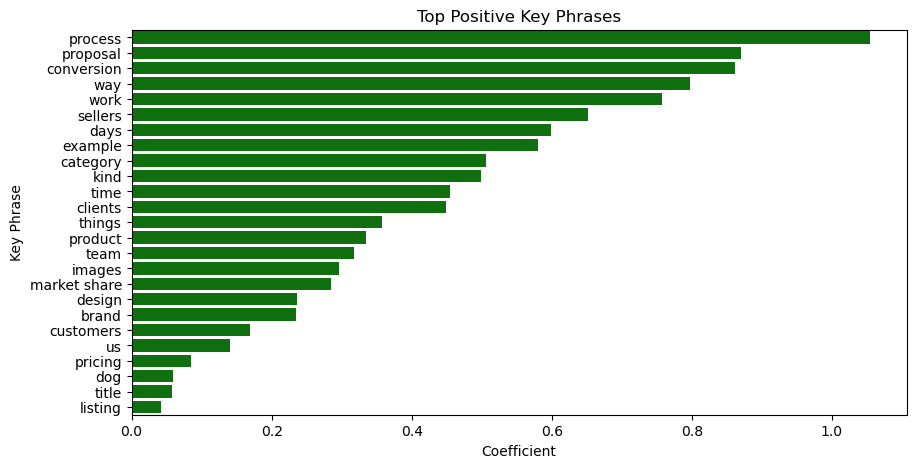

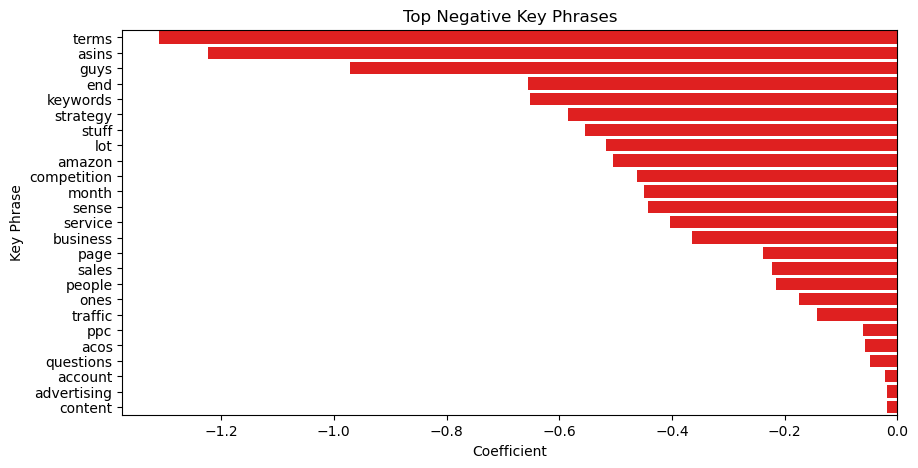

In [13]:
# Separate positive and negative coefficients
top_positive = coefficients[coefficients['coefficient'] > 0].head(25)
top_negative = coefficients[coefficients['coefficient'] < 0].head(25)

# Print top_positive and top_negative
print('Positive phrases')
display(top_positive)

print('Negative phrases')
display(top_negative)

# Plotting top positive phrases
plt.figure(figsize=(10,5))
sns.barplot(x='coefficient', y='phrase', data=top_positive, color='green')
plt.title('Top Positive Key Phrases')
plt.xlabel('Coefficient')
plt.ylabel('Key Phrase')
plt.show()

# Plotting top negative phrases
plt.figure(figsize=(10,5))
sns.barplot(x='coefficient', y='phrase', data=top_negative, color='red')
plt.title('Top Negative Key Phrases')
plt.xlabel('Coefficient')
plt.ylabel('Key Phrase')
plt.show()


---
<a id='conclusion'></a>
## 11. Conclusion

TBA for Subtask 8